датасет взят с кэгла. Задача классификации, определить пойдет завтра дождь или нет 

In [217]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import *
import shap
# load JS visualization code to notebook
shap.initjs()



from sklearn.model_selection import train_test_split
import catboost as catb
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

In [218]:
df = pd.read_csv('weatherAUS.csv', sep=',')
df.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No


In [219]:
df.shape

(145460, 23)

In [220]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [221]:
# Посомтрим на пропуски

df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [222]:
# Посмотрим на типы данных в датасете

df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [223]:
target_name = 'RainTomorrow'
base_feature_names = df.columns.drop([target_name]).tolist()
cat_feature_names = df.select_dtypes(include='object').columns.drop([target_name]).tolist()
num_feature_names = df.columns.drop([target_name] + cat_feature_names).tolist()

In [224]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [225]:
# преобразуем target

df.loc[df['RainTomorrow'] == 'No', 'RainTomorrow'] = 0
df.loc[df['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1

In [226]:
df['RainTomorrow'].unique()

array([0, 1, nan], dtype=object)

In [227]:
df['RainTomorrow'].isna().sum()

3267

In [228]:
#выкинем  значения, где наш таргет неопределен

df = df[df['RainTomorrow'].notna()]

In [229]:
# поменяем тип данных

df = df.astype({"RainTomorrow": int})

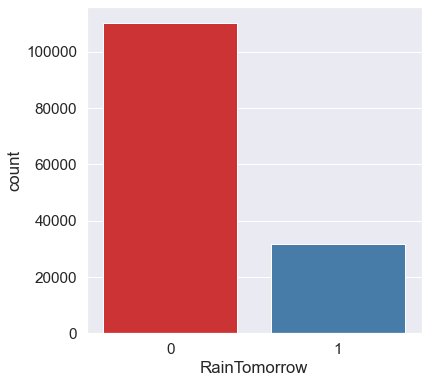

In [230]:
#Посмотрим на соотношение классов 

f, ax = plt.subplots(figsize=(6, 6))
ax = sns.countplot(x="RainTomorrow", data=df, palette="Set1")
plt.show()

In [231]:
#Посмотрим на соотношение классов в численном выражении

df['RainTomorrow'].value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

### Корреляция целевой переменной с базовыми признаками

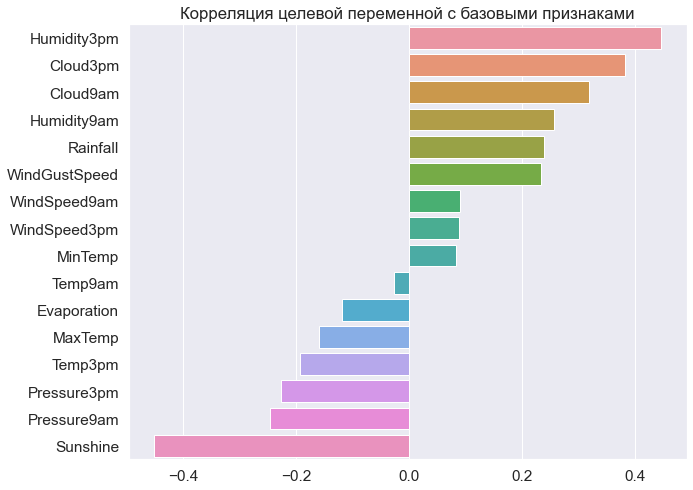

In [232]:
corr_with_target = df[base_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция целевой переменной с базовыми признаками')
plt.show()

### Матрица корреляций признаков

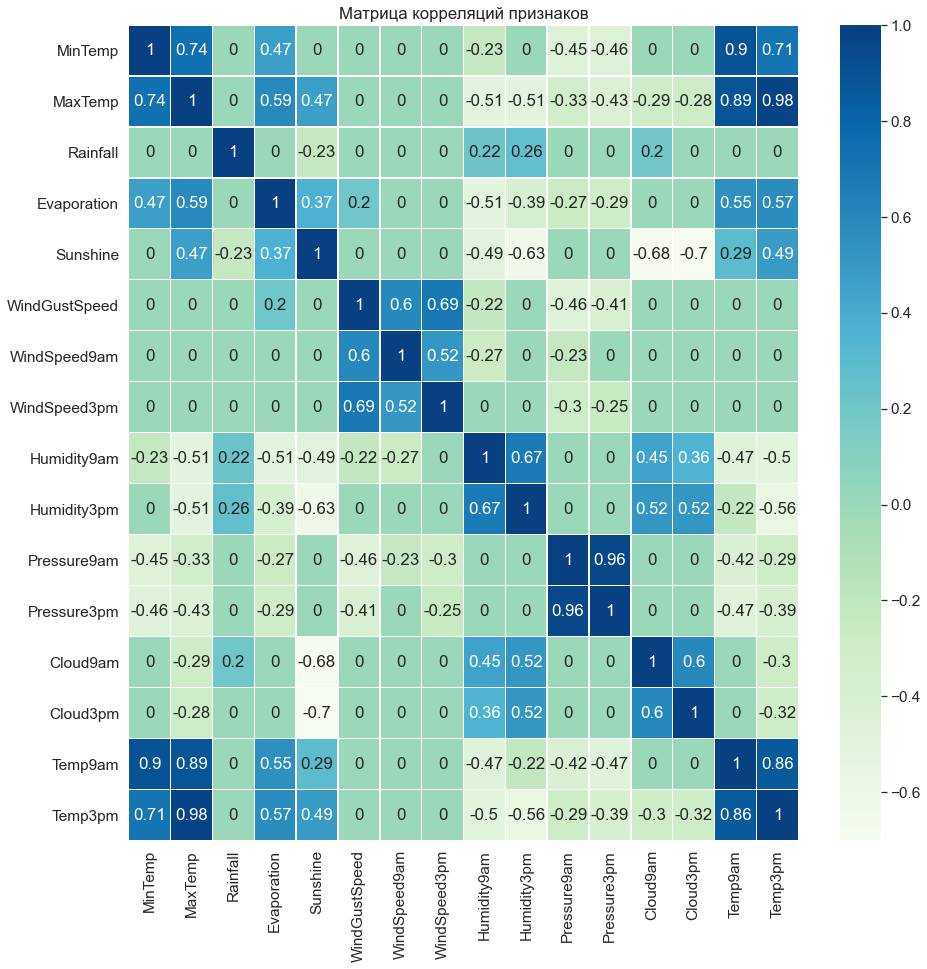

In [233]:
plt.figure(figsize = (15,15))

sns.set(font_scale=1.4)

corr_matrix = df[base_feature_names].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляций признаков')
plt.show()

### Анализ выбросов

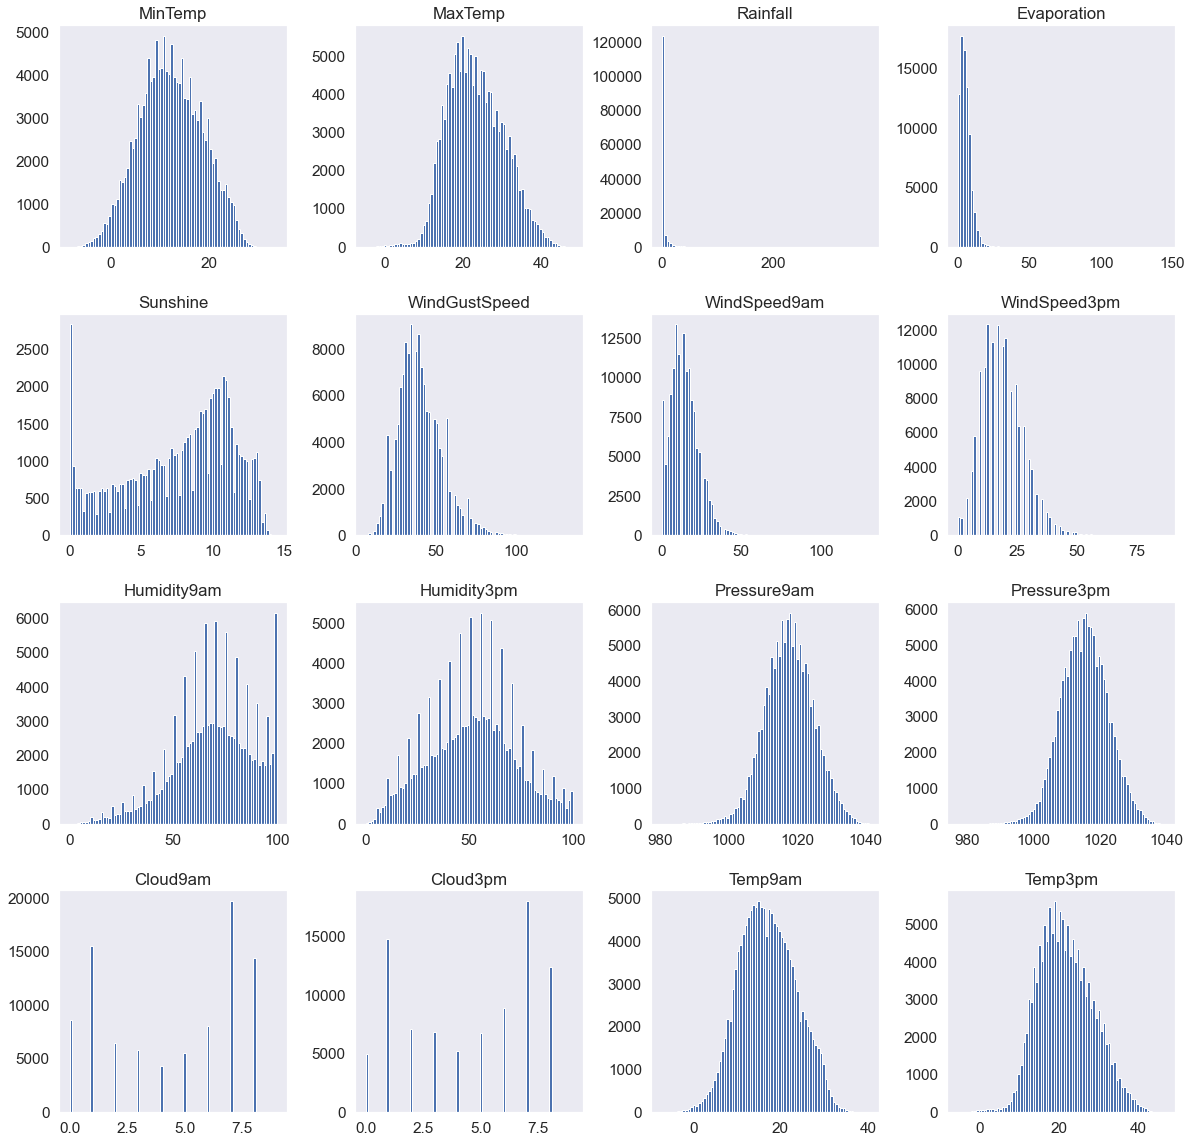

In [234]:
df[num_feature_names].hist(figsize=(20, 20), bins=80, grid=False);

In [235]:
# посомтрим на сводную статистику в числовыхпеременных

print(round(df[num_feature_names].describe()),2)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  141556.0  141871.0  140787.0      81350.0   74377.0       132923.0   
mean       12.0      23.0       2.0          5.0       8.0           40.0   
std         6.0       7.0       8.0          4.0       4.0           14.0   
min        -8.0      -5.0       0.0          0.0       0.0            6.0   
25%         8.0      18.0       0.0          3.0       5.0           31.0   
50%        12.0      23.0       0.0          5.0       8.0           39.0   
75%        17.0      28.0       1.0          7.0      11.0           48.0   
max        34.0      48.0     371.0        145.0      14.0          135.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
count      140845.0      139563.0     140419.0     138583.0     128179.0   
mean           14.0          19.0         69.0         51.0       1018.0   
std             9.0           9.0         19.0         21.0          7.0   
mi

In [236]:
# обработаем пропущенные значения числовых признаков в X_train

for col in df[num_feature_names]:
    col_median = df[col].median()
    df[col].fillna(col_median, inplace=True) 

In [237]:
# проверим наличие пропусков еще раз X_train

df[num_feature_names].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [238]:
# проверка количества элементов в категориальных переменных

for var in cat_feature_names:
    
    print(var, ' содержит ', len(df[var].unique()), ' labels')

Date  содержит  3436  labels
Location  содержит  49  labels
WindGustDir  содержит  17  labels
WindDir9am  содержит  17  labels
WindDir3pm  содержит  17  labels
RainToday  содержит  3  labels


In [239]:
# обработаем признак RainToday

df['RainToday'].fillna(df['RainToday'].mode()[0], inplace=True)

# переведем признак RainToday в числовой
df.loc[df['RainToday'] == 'No', 'RainToday'] = 0
df.loc[df['RainToday'] == 'Yes', 'RainToday'] = 1
df['RainToday'].unique()
df = df.astype({"RainToday": int})

Мы видим, что есть переменная Date, которую нужно предварительно обработать. Предварительную обработку сделаем позже.

In [240]:
# приведем фичу Date к нормальному формату даты 

df['Date'] = pd.to_datetime(df['Date'])

In [241]:
# извлечь год, месяц и день из числа

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [242]:
# удалим столбец Date

df.drop('Date', axis=1, inplace = True)

In [243]:
df.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,4.8,8.5,W,44.0,W,WNW,...,1007.1,8.0,5.0,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,4.8,8.5,WNW,44.0,NNW,WSW,...,1007.8,5.0,5.0,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,4.8,8.5,WSW,46.0,W,WSW,...,1008.7,5.0,2.0,21.0,23.2,0,0,2008,12,3


In [244]:
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday          int32
RainTomorrow       int32
Year               int64
Month              int64
Day                int64
dtype: object

In [245]:
# Обновим наши список наших категориальных фичей, чтобы в нем не было даты, которая была типом "object"
cat_feature_names = df.select_dtypes(include='object').columns.tolist()
cat_feature_names

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

In [246]:
# вывести процент пропущенных значений в категориальных переменных в X_train

df[cat_feature_names].isnull().mean()

Location       0.000000
WindGustDir    0.065615
WindDir9am     0.070418
WindDir3pm     0.026570
dtype: float64

In [247]:
# присвоим отсутствующим категориальным переменным наиболее частое значение

df['WindGustDir'].fillna(df['WindGustDir'].mode()[0], inplace=True)
df['WindDir9am'].fillna(df['WindDir9am'].mode()[0], inplace=True)
df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0], inplace=True)

In [248]:
#кодируем все категориальные признаки с помощью get_dummies
df = pd.get_dummies(df, columns = cat_feature_names, prefix_sep = "_", drop_first = True) 

In [249]:
X = df.drop(columns=target_name)
y = df[target_name]

In [250]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [251]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((99535, 113), (42658, 113), (99535,), (42658,))

In [252]:
model_catb = CatBoostRegressor(random_state=42,
                               n_estimators=1200, 
                               learning_rate=0.025,
                              )
model_catb.fit(X_train, y_train, verbose=False, plot=False)

In [253]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

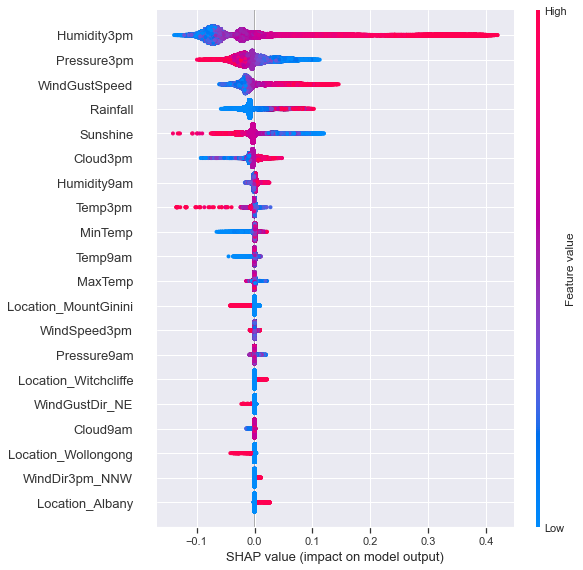

In [254]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Выводы:
1. Признак humidity3pm (относительная влажность воздуха в 3 часа дня) - чем выше значение, тем более вероятно что на следующий день пойдет дождь и наоборот
2. Признак pressure3pm (давление в 3 часа дня) - чем выше значение, тем менее вероятно что на следующий день пойдет дождь и наоборот
3. Признак WindGustSpeed (порывы ветра) - чем выше значение, тем более вероятно что на следующий день пойдет дождь и наоборот
4. Признак Rainfall (осадки) - чем выше значение, тем более вероятно что на следующий день пойдет дождь и наоборот.
5. Признак Sunshine (солнечный свет) - чем выше значение, тем менее вероятно что на следующий день пойдет дождь и наоборот.
5. Признак Cloud3pm (облачность в 3 часа дня) - чем выше значение, тем более вероятно что на следующий день пойдет дождь и наоборот.

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")